In [1]:
from model.lstm import LSTM, DeepLSTM
from model.test import eval_padded
from data.generator import get_vocab_size, generate_batch
from utils.rnn_utils import get_mask, get_hidden_mask, reduce_lens, save_states, populate_first_output, build_first_output, batch_acc

import torch
from tqdm.notebook import trange
import seaborn as sns

In [104]:
MAX_ITER = 1500
HID_SIZE = 100
BS = 16
LR = 3e-4
DEVICE = 'cuda'

In [105]:
encoder = DeepLSTM(
    input_size=get_vocab_size(),
    hidden_size=HID_SIZE,
    output_size=get_vocab_size(),
    batch_size=BS,
).to(DEVICE)

decoder = DeepLSTM(
    input_size=get_vocab_size(),
    hidden_size=HID_SIZE,
    output_size=get_vocab_size(),
    batch_size=BS,
).to(DEVICE)

In [106]:
enc_dec_parameters = [p for p in encoder.parameters()] + [p for p in decoder.parameters()]

In [107]:
padded_samples_batch, padded_targets_batch, samples_len, targets_len = generate_batch(length=1, nesting=1, batch_size=BS)
padded_samples_batch, padded_targets_batch = padded_samples_batch.to(DEVICE), padded_targets_batch.to(DEVICE)

In [108]:
loss = torch.nn.CrossEntropyLoss(reduction='none')
opt = torch.optim.Adam(enc_dec_parameters, lr=LR)

In [109]:
def step(encoder, decoder, sample, target, samples_len, targets_len, loss, opt, device):
    opt.zero_grad()
    encoder.train()
    decoder.train()
    outputs = []
    h_dict, c_dict = {1: {}, 2: {}}, {1: {}, 2: {}}
    samples_len = samples_len.copy()
    targets_len = targets_len.copy()
    hid_size = encoder.h_t_1.size(1)
    
    for char_pos in range(sample.size(1)):
        hidden_mask = get_hidden_mask(samples_len, hid_size, device)
        output = encoder(sample[:, char_pos, :].squeeze(), hidden_mask)
        samples_len = reduce_lens(samples_len)
        h_dict, c_dict = save_states(encoder, h_dict, c_dict, samples_len)
    
    decoder.set_states(h_dict, c_dict)
    output = decoder(torch.ones(sample[:, char_pos, :].squeeze().size(), device=device),
                     torch.ones(hidden_mask.size(), device=device))
    outputs.append(output)
    targets_len_copy = targets_len.copy()
    targets_len_copy = reduce_lens(targets_len_copy)
                
    for char_pos in range(target.size(1) - 1):
        hidden_mask = get_hidden_mask(targets_len_copy, hid_size, device)
        output = decoder(target[:, char_pos, :].squeeze(), hidden_mask)
        targets_len_copy = reduce_lens(targets_len_copy)
        outputs.append(output)
        
    count_nonzero = 0
    cumulative_loss = 0
    loss_masks = []
    for char_pos, output in enumerate(outputs):
        loss_masks.append(get_mask(targets_len, device))
        targets_len = reduce_lens(targets_len)
        char_loss = loss(output, torch.argmax(target[:, char_pos, :].squeeze(), dim=1)) * loss_masks[-1]
        count_nonzero += (char_loss != 0).sum()
        cumulative_loss += torch.sum(char_loss)
    avg_loss = cumulative_loss / count_nonzero
    acc = batch_acc(outputs, target, loss_masks)
    
    avg_loss.backward()
    opt.step()

    encoder.detach_states()
    decoder.detach_states()
    return avg_loss.item(), acc.item()

In [110]:
def encdec_fwd_padded_batch(encoder, decoder, sample, target, samples_len, targets_len, device):
    outputs = []
    h_dict, c_dict = {1: {}, 2: {}}, {1: {}, 2: {}}
    samples_len = samples_len.copy()
    targets_len = targets_len.copy()
    hid_size = encoder.h_t_1.size(1)
    
    for char_pos in range(sample.size(1)):
        hidden_mask = get_hidden_mask(samples_len, hid_size, device)
        output = encoder(sample[:, char_pos, :].squeeze(), hidden_mask)
        samples_len = reduce_lens(samples_len)
        h_dict, c_dict = save_states(encoder, h_dict, c_dict, samples_len)
        
    decoder.set_states(h_dict, c_dict)
    output = decoder(torch.ones(sample[:, char_pos, :].squeeze().size(), device=device),
                     torch.ones(hidden_mask.size(), device=device))
    outputs.append(output)
    targets_len_copy = targets_len.copy()
    targets_len_copy = reduce_lens(targets_len_copy)

    for char_pos in range(target.size(1) - 1):
        hidden_mask = get_hidden_mask(targets_len_copy, hid_size, device)
        output = decoder(target[:, char_pos, :].squeeze(), hidden_mask)
        targets_len_copy = reduce_lens(targets_len_copy)
        outputs.append(output)
    encoder.detach_states()
    decoder.detach_states()
    return outputs

In [111]:
metrics = {
    "train_loss": [],
    "train_acc": [],
}

for it in trange(MAX_ITER):
    loss_val, acc_val = step(encoder, decoder, padded_samples_batch, padded_targets_batch, samples_len, targets_len, loss, opt, DEVICE)
    metrics["train_loss"].append(loss_val)
    metrics["train_acc"].append(acc_val)

  0%|          | 0/1500 [00:00<?, ?it/s]

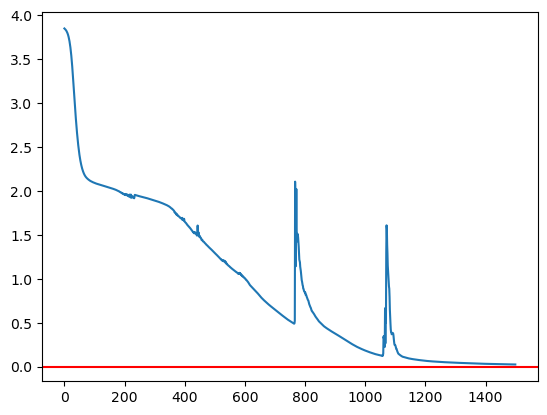

In [112]:
ax = sns.lineplot(metrics["train_loss"])
_ = ax.axhline(0, color='red')

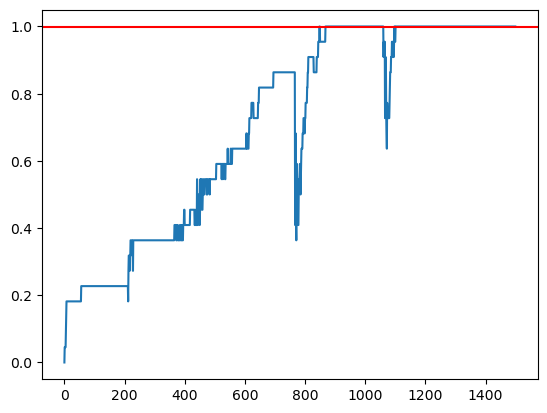

In [113]:
ax = sns.lineplot(metrics["train_acc"])
_ = ax.axhline(0.999, color='red')

In [114]:
outputs = encdec_fwd_padded_batch(encoder, decoder, padded_samples_batch, padded_targets_batch, samples_len, targets_len, DEVICE)

In [115]:
targets_len_cp = targets_len.copy()

In [116]:
loss_masks = []
for char_pos, output in enumerate(outputs):
    loss_masks.append(get_mask(targets_len_cp, DEVICE))
    targets_len_cp = reduce_lens(targets_len_cp)

In [117]:
batch_acc(outputs, padded_targets_batch, loss_masks)

tensor(1., device='cuda:0')

In [186]:
eval_encdec_padded(encoder, decoder, padded_samples_batch, padded_targets_batch, samples_len, targets_len, DEVICE)

print((2*7))bbbbbbbbbbbbbbbbbbbbbbbb
out: 142
target: 14b



In [62]:
def eval_encdec_padded(encoder, decoder, padded_samples_batch, padded_targets_batch, samples_len, targets_len, device):
    outputs = encdec_fwd_padded_batch(encoder, decoder, padded_samples_batch, padded_targets_batch, samples_len, targets_len, device)
    eval_padded(outputs, padded_targets_batch, padded_samples_batch)

In [14]:
def batch_acc(outputs, target, loss_masks):
    masked_outputs = torch.concat(
        [(output.argmax(1)*mask).unsqueeze(1) for output, mask in zip(outputs, loss_masks)], dim=1)
    not_valid_outputs = sum([sum(mask == False) for mask in loss_masks])
    valid_outputs = sum([sum(mask == True) for mask in loss_masks])
    outputs_equal_to_targets = (masked_outputs == target.argmax(2)).sum()
    return (outputs_equal_to_targets - not_valid_outputs)/valid_outputs